In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from subprocess import run

hdecaypath = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "hdecay/")


def runHdecay(mStart, mEnd, nStep):
    with open(os.path.join(hdecaypath, "hdecay.in"), "r") as infile:
        lines = infile.readlines()
    assert lines[11].startswith("MABEG")
    lines[11] = "MABEG    = {:e}\n".format(mStart)
    assert lines[12].startswith("MAEND")
    lines[12] = "MAEND    = {:e}\n".format(mEnd)
    assert lines[13].startswith("NMA")
    lines[13] = "NMA      = {}\n".format(nStep)
    with open(os.path.join(hdecaypath, "hdecay.in"), "w") as outfile:
        outfile.writelines(lines)
    run(os.path.join(hdecaypath, "run"), cwd=hdecaypath)
    brs = pd.concat(
        (
            pd.read_csv(
                os.path.join(hdecaypath, "br.sm1"),
                sep=r"\s+",
                skiprows=3,
                names=["MH", "bb", "tautau", "mumu", "ss", "cc", "tt"],
            ).set_index("MH"),
            pd.read_csv(
                os.path.join(hdecaypath, "br.sm2"),
                sep=r"\s+",
                skiprows=3,
                names=["MH", "gg", "gamgam", "Zgam", "WW", "ZZ", "wtot"],
            ).set_index("MH"),
        ),
        axis=1,
    )
    return brs[list(brs)[:-1]].multiply(brs.wtot, axis=0)


# BSM BRs --- no EW corrections, large mass range

First load the official YR4 BSM values

In [2]:
widths_BSM_YR4 = pd.read_excel(
    "https://twiki.cern.ch/twiki/pub/LHCPhysics/LHCHWG/Higgs_XSBR_YR4_update.xlsx",
    header=[1, 2],
    sheet_name="YR4 BSM Width",
    skiprows=[3, 4],
    skipfooter=2,
)
assert np.allclose(
    widths_BSM_YR4["Unnamed: 0_level_0", "MH"], widths_BSM_YR4[" H → 2 fermions", "MH"]
)

yr4w = pd.DataFrame()
yr4w["MH"] = widths_BSM_YR4["Unnamed: 0_level_0", "MH"]
yr4w["bb"] = widths_BSM_YR4[" H → 2 fermions", " H → bb"]
yr4w["tautau"] = widths_BSM_YR4[" H → 2 fermions", " H → ττ"]
yr4w["mumu"] = widths_BSM_YR4[" H → 2 fermions", " H → μμ"]
yr4w["cc"] = widths_BSM_YR4[" H → 2 fermions", " H → cc"]
yr4w["tt"] = widths_BSM_YR4[" H → 2 fermions", " H → tt"]
yr4w["gg"] = widths_BSM_YR4["H → VV (gauge bosons)", " H → gg"]
yr4w["gamgam"] = widths_BSM_YR4["H → VV (gauge bosons)", " H → γγ"]
yr4w["Zgam"] = widths_BSM_YR4["H → VV (gauge bosons)", " H → Zγ"]
yr4w["WW"] = widths_BSM_YR4["H → VV (gauge bosons)", " H → WW"]
yr4w["ZZ"] = widths_BSM_YR4["H → VV (gauge bosons)", " H → ZZ"]
yr4w.set_index("MH", drop=True, inplace=True)



Now evaluate the hdecay BRs one a slightly larger target grid and merge the two dfs, using the YR4 values if available.


 No electroweak corrections...


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DENORMAL


 No electroweak corrections...


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


 No electroweak corrections...


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


 No electroweak corrections...


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


 No electroweak corrections...


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


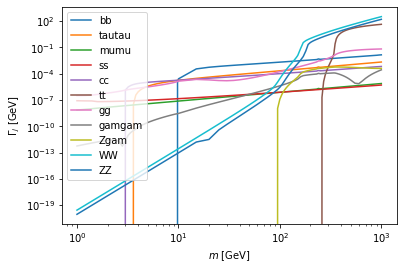

In [3]:
assert np.allclose(
    np.sort(
        np.concatenate(
            (
                np.linspace(20, 145, 26),
                [125.09],
                np.linspace(150, 490, 35),
                np.linspace(500, 900, 9),
            )
        )
    ),
    yr4w.index,
)

hdecayw = pd.concat(
    (
        runHdecay(1, 9.8, 45),
        runHdecay(10, 145, 28),
        runHdecay(125.09, 125.09, 1),
        runHdecay(150, 490, 35),
        runHdecay(500, 1000, 11),
    )
).sort_index()

w = hdecayw
w.loc[yr4w.index, list(yr4w)] = yr4w

plt.figure()
for val in list(w):
    plt.plot(w.index, w[val], label=val)
plt.yscale("log")
plt.xlabel("$m$ [GeV]")
plt.ylabel("$\Gamma_j$ [GeV]")
plt.xscale("log")
plt.legend()
plt.show()


Now convert from partial widths into BRs

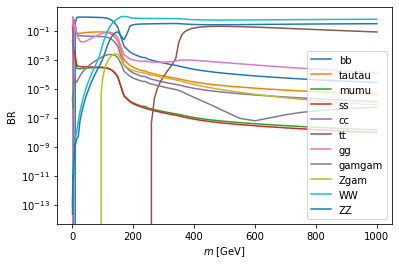

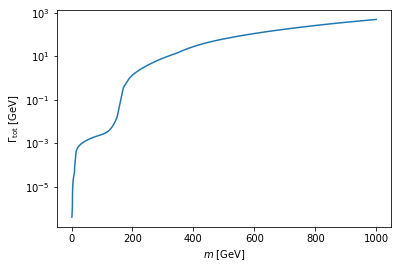

In [4]:
br = w.copy()
br["wtot"] = np.sum(w, axis=1)
for n in list(w):
    br[n] = br[n] / br.wtot

plt.figure()
for val in list(w):
    plt.plot(br.index, br[val], label=val)
plt.yscale("log")
plt.xlabel("$m$ [GeV]")
plt.ylabel("BR")
plt.legend()
plt.show()

plt.figure()
plt.plot(br.index, br.wtot)
plt.yscale("log")
plt.xlabel("$m$ [GeV]")
plt.ylabel("$\Gamma_\mathrm{tot}$ [GeV]")
plt.show()


# SM EW corrections

Use the YR4 numbers, but re-add H->ss using the numbers without EW corrections.

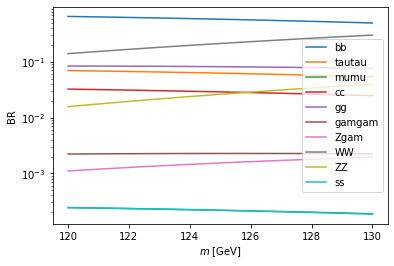

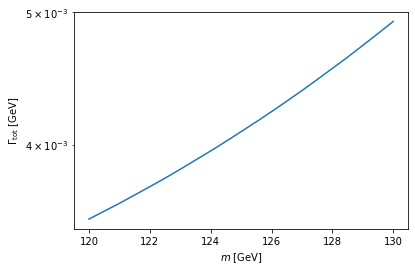

In [42]:
from scipy.interpolate import interp1d

brs_SM_YR4 = pd.read_excel(
    "https://twiki.cern.ch/twiki/pub/LHCPhysics/LHCHWG/Higgs_XSBR_YR4_update.xlsx",
    header=[1, 2],
    sheet_name="YR4 SM BR",
    skiprows=[1, 4, 5],
)
assert np.allclose(brs_SM_YR4.MH.iloc[:, 0], brs_SM_YR4.MH.iloc[:, 1])
assert np.allclose(brs_SM_YR4.MH.iloc[:, 0], brs_SM_YR4.MH.iloc[:, 2])

brSM = pd.DataFrame(
    {
        "mH": brs_SM_YR4.MH.iloc[:, 0],
        "bb": brs_SM_YR4[(" H → bb", "BR")],
        "tautau": brs_SM_YR4[" H → ττ", "BR"],
        "mumu": brs_SM_YR4[" H → μμ", "BR"],
        "cc": brs_SM_YR4[" H → cc", "BR"],
        "gg": brs_SM_YR4[" H → gg", "BR"],
        "gamgam": brs_SM_YR4[" H → γγ", "BR"],
        "Zgam": brs_SM_YR4[" H → Zγ", "BR"],
        "WW": brs_SM_YR4[" H → WW", "BR"],
        "ZZ": brs_SM_YR4[" H → ZZ", "BR"],
        "wtot": brs_SM_YR4[" H → ZZ", "ΓH"],  # misaligned excel columns
    }
).set_index("mH")

gamss = interp1d(w.index, w.ss)

brSum = brSM[[x for x in list(brSM) if x != "wtot"]].sum(axis="columns")
brSM.loc[:, [x for x in list(brSM) if x != "wtot"]] = brSM.loc[
    :, [x for x in list(brSM) if x != "wtot"]
].multiply(
    brSM.wtot / brSum, axis="index"
)  # correct BRs to 1
brSM["ss"] = gamss(brSM.index)
brSM.wtot += brSM["ss"]
brSM.loc[:, [x for x in list(brSM) if x != "wtot"]] = brSM.loc[
    :, [x for x in list(brSM) if x != "wtot"]
].divide(brSM.wtot, axis="index")


plt.figure()
for val in [x for x in list(brSM) if x != "wtot"]:
    plt.plot(brSM.index, brSM[val], label=val)
plt.yscale("log")
plt.xlabel("$m$ [GeV]")
plt.ylabel("BR")
plt.legend()
plt.show()

plt.figure()
plt.plot(brSM.index, brSM.wtot)
plt.yscale("log")
plt.xlabel("$m$ [GeV]")
plt.ylabel("$\Gamma_\mathrm{tot}$ [GeV]")
plt.show()


# Export to C++ file

In [43]:
from helpers import *

with cppDataFile(
    "../src/predictions/data/YR4Brs.cpp", scriptname="tools/getYR4Brs.ipynb"
) as cppf:
    cppf.write("const auto bsmGridBrs = ")
    cppf.write(grid2CppString([br.index.values]))

    for n in list(w):
        cppf.write("const auto br{} = ".format(n))
        cppf.write(values2CppString(br[n].values))

    cppf.write("const auto wtot = ")
    cppf.write(values2CppString(br.wtot.values))

    cppf.write("const auto smGridBrs = ")
    cppf.write(grid2CppString([brSM.index.values]))

    for n in [x for x in list(brSM) if x != "wtot"]:
        cppf.write("const auto br{}SM = ".format(n))
        cppf.write(values2CppString(brSM[n].values))

    cppf.write("const auto wtotSM = ")
    cppf.write(values2CppString(brSM.wtot.values))
